# Classify emotions in text with BiLSTM model

## Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('drive/MyDrive/dataset/texts/'): #path file
    for filename in filenames:
        print(os.path.join(dirname, filename))

drive/MyDrive/dataset/texts/dev_sent_emo.csv
drive/MyDrive/dataset/texts/test_sent_emo.csv
drive/MyDrive/dataset/texts/train_sent_emo.csv
drive/MyDrive/dataset/texts/df_train.csv


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 53.7 MB/s 
     |████████████████████████████████| 182 kB 70.8 MB/s 


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup, BertModel

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import accuracy_score,matthews_corrcoef
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io
# % matplotlib inline

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!nvidia-smi

Mon Dec 19 12:28:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# identify and specify the GPU as the device, later in training loop we will load data into device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [ ]:
device = torch.device("cuda")

## Load and Convert Dataset

###Load csv dataset

In [ ]:
#ganti dataset
# df_train = pd.read_csv("drive/MyDrive/dataset/texts/train_emo.csv", delimiter=',', header=1, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])
# df_test = pd.read_csv("drive/MyDrive/dataset/texts/test_emo.csv", delimiter=',', header=1, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])
#df_val = pd.read_csv("drive/MyDrive/dataset/texts/dev_emo.csv", delimiter=',', header=1, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])

#coba train
df_train_raw = pd.read_csv("drive/MyDrive/dataset/texts/train_sent_emo.csv", delimiter=',', header=0, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])
df_val_raw = pd.read_csv("drive/MyDrive/dataset/texts/dev_sent_emo.csv", delimiter=',', header=0, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])

df_train = df_train_raw[['Utterance','Emotion']]
df_val = df_val_raw[['Utterance','Emotion']]

###Undersampling train dataset

In [ ]:
df_tr_temp = df_train
df_val_temp = df_val

In [ ]:
from sklearn.utils import resample,shuffle

df_emo_1 = df_tr_temp[df_tr_temp['Emotion'] == 'neutral']
df_1_upsampled = resample(df_emo_1,random_state=42,n_samples=683,replace=True)

df_emo_2 = df_tr_temp[df_tr_temp['Emotion'] == 'joy']
df_2_upsampled = resample(df_emo_2,random_state=0,n_samples=683,replace=True)

df_emo_3 = df_tr_temp[df_tr_temp['Emotion'] == 'surprise']
df_3_upsampled = resample(df_emo_3,random_state=42,n_samples=683,replace=True)

df_emo_4 = df_tr_temp[df_tr_temp['Emotion'] == 'anger']
df_4_upsampled = resample(df_emo_4,random_state=42,n_samples=683,replace=True)

df_emo_5 = df_tr_temp[df_tr_temp['Emotion'] == 'sadness']
# df_emo_6 = df_tr_temp[df_tr_temp['Emotion'] == 'fear']
# df_emo_7 = df_tr_temp[df_tr_temp['Emotion'] == 'disgust']

# df_train = pd.concat([df_1_upsampled,df_2_upsampled,df_3_upsampled,df_4_upsampled,df_emo_5,df_emo_6,df_emo_7])
df_train = pd.concat([df_1_upsampled,df_2_upsampled,df_3_upsampled,df_4_upsampled,df_emo_5])

In [ ]:
df_train['Emotion'].value_counts()

neutral     683
joy         683
surprise    683
anger       683
sadness     683
Name: Emotion, dtype: int64

In [ ]:
df_train = df_train.sample(frac=1,random_state=42).reset_index()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


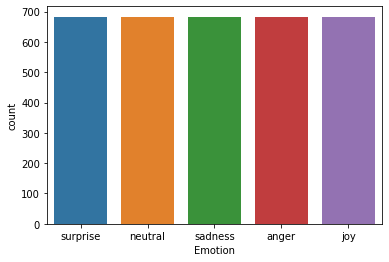

In [ ]:
sns.countplot(df_train['Emotion'])

###Validation dataset

In [ ]:
df_emo_1_val = df_val_temp[df_val_temp['Emotion'] == 'neutral']
df_1_upsampled = resample(df_emo_1_val,random_state=42,n_samples=114,replace=True)

df_emo_2_val = df_val_temp[df_val_temp['Emotion'] == 'joy']
df_2_upsampled = resample(df_emo_2_val,random_state=0,n_samples=114,replace=True)

df_emo_3_val = df_val_temp[df_val_temp['Emotion'] == 'surprise']
df_3_upsampled = resample(df_emo_3_val,random_state=42,n_samples=114,replace=True)

df_emo_4_val = df_val_temp[df_val_temp['Emotion'] == 'anger']
df_4_upsampled = resample(df_emo_4_val,random_state=42,n_samples=114,replace=True)

df_emo_5_val = df_val_temp[df_val_temp['Emotion'] == 'sadness']
# df_emo_6_val = df_val_temp[df_val_temp['Emotion'] == 'fear']
# df_emo_7_val = df_val_temp[df_val_temp['Emotion'] == 'disgust']

# df_val = pd.concat([df_1_upsampled,df_2_upsampled,df_3_upsampled,df_4_upsampled,df_emo_5_val,df_emo_6_val,df_emo_7_val])
df_val = pd.concat([df_1_upsampled,df_2_upsampled,df_3_upsampled,df_4_upsampled,df_emo_5_val])

In [ ]:
df_val['Emotion'].value_counts()

neutral     114
joy         114
surprise    114
anger       114
sadness     111
Name: Emotion, dtype: int64

In [ ]:
df_train = df_train.sample(frac=1,random_state=42).reset_index(drop=True)
df_val = df_val.sample(frac=1,random_state=42).reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_train['emotion_enc'] = labelencoder.fit_transform(df_train['Emotion'])
df_val['emotion_enc'] = labelencoder.fit_transform(df_val['Emotion'])

In [ ]:
# df_train[['Emotion','emotion_enc']].drop_duplicates(keep='first')

In [ ]:
# df_val[['Emotion','emotion_enc']].drop_duplicates(keep='first')

In [ ]:
df_train.rename(columns={'Emotion':'label_desc'},inplace=True)
df_train.rename(columns={'emotion_enc':'label'},inplace=True)

df_val.rename(columns={'Emotion':'label_desc'},inplace=True)
df_val.rename(columns={'emotion_enc':'label'},inplace=True)

In [ ]:
df_train

,index,Utterance,label_desc,label
0,3366,He musta been sweeping. They found a broom in ...,neutral,2
1,4693,Are you afraid youre gonna run out?!,anger,0
2,7881,"Oh, I want to look too! . Yikes!",surprise,4
3,9488,Oh no!,surprise,4
4,5106,I love that idea!,joy,1
...,...,...,...,...
3410,6456,"What are you talking about, Ross, you just sai...",anger,0
3411,902,Monica? You gonna be very proud of me. I just ...,joy,1
3412,6787,No! No!! No! Can I speak to someone in charge ...,anger,0
3413,9085,We can't. We're not pharmacists!,sadness,3


##Cleaning Dataset

In [ ]:
# import nltk, string, re

# def remove_specials(dataframe, target_col_name, new_col_name):
#   pattern = r"[^a-zA-Z0-9]+"
#   # Remove special characters from a string
#   dataframe[new_col_name] = dataframe[target_col_name].apply(lambda x: re.sub(pattern, ' ', x))
#   return dataframe

In [ ]:
# df_cleaned_tr = remove_specials(df_train,'Utterance','Cleaned_utterance')
# df_cleaned_val = remove_specials(df_val,'Utterance','Cleaned_utterance')

# df_cleaned_val.head()

##Tokenize Dataset

In [ ]:
## create label and sentence list
# sentences_train = df_cleaned_tr.Cleaned_utterance.values
# sentences_val = df_cleaned_val.Cleaned_utterance.values
sentences_train = df_train.Utterance.values
sentences_val = df_val.Utterance.values

#check distribution of data based on labels
print("Distribution of train data based on labels: \n",df_train.label.value_counts())
print("Distribution of test data based on labels: \n",df_val.label.value_counts())

# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.

MAX_LEN = 256

## Import BERT tokenizer, that is used to convert our text into tokens that corresponds to BERT library
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased',do_lower_case=True)

Distribution of train data based on labels: 
 2    683
0    683
4    683
1    683
3    683
Name: label, dtype: int64
Distribution of test data based on labels: 
 4    114
0    114
1    114
2    114
3    111
Name: label, dtype: int64


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
#tokenize masing-masing train dan test dataset
train_inputs = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences_train]
# train_labels = df_cleaned_tr.label.values
train_labels = df_train.label.values

validation_inputs = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences_val]
# validation_labels = df_cleaned_val.label.values
validation_labels = df_val.label.values

print("Actual sentence before tokenization: ",sentences_train[2])
print("Encoded Input from dataset: ",train_inputs[2])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Actual sentence before tokenization:  Oh, I want to look too! . Yikes!
Encoded Input from dataset:  [101, 2821, 1010, 1045, 2215, 2000, 2298, 2205, 999, 1012, 12316, 9681, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
## Create attention mask
attention_masks_train = []
attention_masks_val = []
## Create a mask of 1 for all input tokens and 0 for all padding tokens
train_masks = [[float(i>0) for i in seq] for seq in train_inputs]
validation_masks = [[float(i>0) for i in seq] for seq in validation_inputs]

## Dataset Prep for training

In [ ]:
x_train = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences_train]
x_train = np.array(x_train)
enc = OneHotEncoder()
y = enc.fit_transform(df_train[['label_desc']])
y = y.toarray()

In [ ]:
# convert all our data into torch tensors, required data type for our model
# train_inputs = torch.tensor(train_inputs)
# validation_inputs = torch.tensor(validation_inputs)
# train_labels = torch.tensor(train_labels)
# validation_labels = torch.tensor(validation_labels)
# train_masks = torch.tensor(train_masks)
# validation_masks = torch.tensor(validation_masks)

# # Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
# batch_size = 32

# # Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# # with an iterator the entire dataset does not need to be loaded into memory
# train_data = TensorDataset(train_inputs,train_masks,train_labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

# validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
# validation_sampler = RandomSampler(validation_data)
# validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

### Lets see whats there in traindata set 

In [ ]:
# train_data[0]

In [ ]:
# type(train_dataloader)

## Define Model that will be trained

###Parameter dan Embedding

In [ ]:
labelencoder.classes_

array(['anger', 'joy', 'neutral', 'sadness', 'surprise'], dtype=object)

In [ ]:
embed_size = 768 # how big is each word vector
max_features = 30522 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 256 # max number of words in a question to use
batch_size = 32 # how many samples to process at once
# n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [ ]:
def get_bert_embed_matrix():
    # bert = BertModel.from_pretrained('bert-base-uncased')
    bert = BertModel.from_pretrained('distilbert-base-uncased')
    bert_embeddings = list(bert.children())[0]
    bert_word_embeddings = list(bert_embeddings.children())[0]
    mat = bert_word_embeddings.weight.data.numpy()
    return mat

In [ ]:
embedding_matrix = get_bert_embed_matrix()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.3.attention.k_lin.weight', 'distilbert.transformer.layer.1.attention.v_lin.bias', 'vocab_layer_norm.bias', 'distilbert.transformer.layer.4.ffn.lin2.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.5.ffn.lin2.weight', 'distilbert.transformer.layer.3.attention.v_lin.weight', 'distilbert.transformer.layer.2.ffn.lin2.weight', 'distilbert.transformer.layer.2.sa_layer_norm.bias', 'distilbert.transformer.layer.1.attention.k_lin.weight', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'distilbert.transformer.layer.3.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.1.attention.v_lin.weight', 'distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'disti

###Proposed Model BiLSTM

In [ ]:
from tensorflow import keras
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Lambda, LSTM, TimeDistributed, Masking, Bidirectional, AveragePooling2D, AveragePooling1D, MaxPool1D, Conv1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.optimizers import Adam
from keras.models import Model, load_model,Sequential
import keras.backend as K
reg = keras.regularizers.l2(l2=0.0001)

opt = keras.optimizers.Adam(learning_rate=0.00001)

model = Sequential()
model.add(Embedding(max_features,
                    embed_size,
                    weights = [embedding_matrix],
                    input_length = maxlen,
                    trainable = True))
model.add(Bidirectional(LSTM(512, activation='tanh', return_sequences=True,dropout=0.1)))
model.add(Bidirectional(LSTM(256, activation='tanh', return_sequences=True,dropout=0.1)))
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=False)))  
model.add(Flatten())
model.add(Dense(64,kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(Dense(32,kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(Dense(5,kernel_regularizer=reg))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 256, 768)          23440896  
                                                                 
 bidirectional_9 (Bidirectio  (None, 256, 1024)        5246976   
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 256, 512)         2623488   
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              656384    
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                      

In [ ]:
#Load trained model
from tensorflow import keras

model_1 = keras.models.load_model('drive/MyDrive/Thesis_code/model/BiLSTM_TER-5emo-bal')
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 256, 768)          23440896  
                                                                 
 bidirectional_12 (Bidirecti  (None, 256, 1024)        5246976   
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 256, 512)         2623488   
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 256)              656384    
 onal)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                      

###Baseline Models

In [ ]:
# baseline_1 = Sequential()
# baseline_1.add(Embedding(max_features,embed_size,weights = [embedding_matrix],input_length = maxlen,trainable = True))
# baseline_1.add(Bidirectional(LSTM(300, return_sequences=True, activation='tanh', dropout=0.4)))
# baseline_1.add(Bidirectional(LSTM(300, return_sequences=False, activation='tanh', dropout=0.4)))
# baseline_1.add(Dense(5,activation='softmax'))

# baseline_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# baseline_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 768)          23440896  
                                                                 
 bidirectional (Bidirectiona  (None, 256, 600)         2565600   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 600)              2162400   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 5)                 3005      
                                                                 
Total params: 28,171,901
Trainable params: 28,171,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseline_2 = Sequential()
baseline_2.add(Embedding(max_features,embed_size,weights = [embedding_matrix],input_length = maxlen,trainable = True))
baseline_2.add(Bidirectional(LSTM(512, return_sequences=True, activation='tanh')))
baseline_2.add(Bidirectional(LSTM(256, return_sequences=False, activation='tanh')))
baseline_2.add(Dense(512))
baseline_2.add(Activation('relu'))
baseline_2.add(Dense(5))
baseline_2.add(Activation('softmax'))

baseline_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
baseline_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 256, 768)          23440896  
                                                                 
 bidirectional_4 (Bidirectio  (None, 256, 1024)        5246976   
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              2623488   
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                

## Train the model

###Train baseline models

In [ ]:
# hist_bs1 = baseline_1.fit(x_train, y, batch_size=32, epochs=20, validation_split=0.15)

Epoch 1/20
91/91 [==============================] - 28s 142ms/step - loss: 1.6084 - accuracy: 0.2398 - val_loss: 1.6076 - val_accuracy: 0.3060
Epoch 2/20
91/91 [==============================] - 11s 124ms/step - loss: 1.6057 - accuracy: 0.3432 - val_loss: 1.6050 - val_accuracy: 0.3255
Epoch 3/20
91/91 [==============================] - 11s 125ms/step - loss: 1.6020 - accuracy: 0.3535 - val_loss: 1.6008 - val_accuracy: 0.3411
Epoch 4/20
91/91 [==============================] - 11s 126ms/step - loss: 1.5941 - accuracy: 0.3663 - val_loss: 1.5902 - val_accuracy: 0.3372
Epoch 5/20
91/91 [==============================] - 12s 128ms/step - loss: 1.5636 - accuracy: 0.3260 - val_loss: 1.5296 - val_accuracy: 0.3353
Epoch 6/20
91/91 [==============================] - 12s 128ms/step - loss: 1.4838 - accuracy: 0.3525 - val_loss: 1.5029 - val_accuracy: 0.3216
Epoch 7/20
91/91 [==============================] - 12s 129ms/step - loss: 1.4557 - accuracy: 0.3604 - val_loss: 1.4888 - val_accuracy: 0.3450

In [ ]:
# hist_bs2 = baseline_2.fit(x_train, y, batch_size=32, epochs=20, validation_split=0.15)

Epoch 1/20
91/91 [==============================] - 23s 193ms/step - loss: 1.5870 - accuracy: 0.3039 - val_loss: 1.5183 - val_accuracy: 0.3177
Epoch 2/20
91/91 [==============================] - 17s 183ms/step - loss: 1.4566 - accuracy: 0.3673 - val_loss: 1.4459 - val_accuracy: 0.3665
Epoch 3/20
91/91 [==============================] - 17s 183ms/step - loss: 1.3716 - accuracy: 0.4176 - val_loss: 1.4083 - val_accuracy: 0.3860
Epoch 4/20
91/91 [==============================] - 17s 184ms/step - loss: 1.3057 - accuracy: 0.4569 - val_loss: 1.3873 - val_accuracy: 0.4230
Epoch 5/20
91/91 [==============================] - 17s 184ms/step - loss: 1.2436 - accuracy: 0.4969 - val_loss: 1.3786 - val_accuracy: 0.4269
Epoch 6/20
91/91 [==============================] - 17s 185ms/step - loss: 1.1979 - accuracy: 0.5138 - val_loss: 1.3798 - val_accuracy: 0.4366
Epoch 7/20
91/91 [==============================] - 17s 185ms/step - loss: 1.1548 - accuracy: 0.5372 - val_loss: 1.3684 - val_accuracy: 0.4386

###Train proposed model

In [ ]:
# hist = model.fit(x_train, y, batch_size=32, epochs=20, validation_split=0.15)

Epoch 1/20
91/91 [==============================] - 30s 238ms/step - loss: 1.6238 - acc: 0.2426 - val_loss: 1.6231 - val_acc: 0.2398
Epoch 2/20
91/91 [==============================] - 20s 218ms/step - loss: 1.6198 - acc: 0.2722 - val_loss: 1.6195 - val_acc: 0.2183
Epoch 3/20
91/91 [==============================] - 20s 218ms/step - loss: 1.6101 - acc: 0.2746 - val_loss: 1.6102 - val_acc: 0.2515
Epoch 4/20
91/91 [==============================] - 20s 216ms/step - loss: 1.5735 - acc: 0.2912 - val_loss: 1.5784 - val_acc: 0.2476
Epoch 5/20
91/91 [==============================] - 20s 217ms/step - loss: 1.5075 - acc: 0.3177 - val_loss: 1.5673 - val_acc: 0.2632
Epoch 6/20
91/91 [==============================] - 20s 218ms/step - loss: 1.4784 - acc: 0.3349 - val_loss: 1.5559 - val_acc: 0.3041
Epoch 7/20
91/91 [==============================] - 20s 219ms/step - loss: 1.4466 - acc: 0.3801 - val_loss: 1.5293 - val_acc: 0.3392
Epoch 8/20
91/91 [==============================] - 20s 220ms/step - 

## Evaluate the trained model

### Define evaluation metrics and confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report, f1_score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
## emotion labels
# label2int = {
#   "anger": 0,
#   "disgust": 1,
#   "fear": 2,
#   "joy": 3,
#   "neutral": 4,
#   "sadness": 5,
#   "surprise": 6
# }

label2int = {
  "anger": 0,
  "joy": 1,
  "neutral": 2,
  "sadness": 3,
  "surprise": 4
}

In [ ]:
# def model_predict(model, test_dataloader):
#     """Perform a forward pass on the trained BERT model to predict probabilities
#     on the test set.
#     """
#     # Put the model into the evaluation mode. The dropout layers are disabled during
#     # the test time.
#     model.eval()

#     y_pred_all = []

#     for i, batch in enumerate(test_dataloader):
#         # Add batch to GPU
#         batch = tuple(t.to(device) for t in batch)
#         # Unpack the inputs from our dataloader
#         x_batch, mask_batch, y_batch = batch

#         y_pred_one = model(x_batch).detach()
#         logits = y_pred_one.cpu().numpy()
#         pred_flat = np.argmax(logits, axis=1).flatten()

#         y_pred_all.append(pred_flat)
#     # Concatenate logits from each batch
#     # all_logits = torch.cat(all_logits, dim=0)

#     # Apply softmax to calculate probabilities
#     # probs = F.softmax(y_pred_all, dim=1).cpu().numpy()

#     return y_pred_all

### Preprocess test dataset

In [ ]:
df_test_raw = pd.read_csv("drive/MyDrive/dataset/texts/test_sent_emo.csv", delimiter=',', header=1, names=['Sr No.','Utterance','Speaker','Emotion','Sentiment','Dialogue_ID','Utterance_ID','Season','Episode','StartTime','EndTime'])
df_test = df_test_raw[['Utterance','Emotion']]

In [ ]:
df_test['Emotion'].value_counts()

neutral     1256
joy          402
anger        345
surprise     280
sadness      208
disgust       68
fear          50
Name: Emotion, dtype: int64

In [ ]:
df_test_temp = df_test

In [ ]:
df_test_temp = df_test_temp[df_test_temp['Emotion'] != 'fear']
df_test_temp = df_test_temp[df_test_temp['Emotion'] != 'disgust']

df_test_temp['Emotion'].value_counts()

neutral     1256
joy          402
anger        345
surprise     280
sadness      208
Name: Emotion, dtype: int64

In [ ]:
df_test = df_test_temp

In [ ]:
df_test['emotion_enc'] = labelencoder.fit_transform(df_test['Emotion'])
df_test.rename(columns={'Emotion':'label_desc'},inplace=True)
df_test.rename(columns={'emotion_enc':'label'},inplace=True)

sentences_test = df_test.Utterance.values

In [ ]:
test_inputs = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences_test]
x_test = np.array(test_inputs)
y_test = enc.fit_transform(df_test[['label_desc']])
y_test = y_test.toarray()

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
y_true=np.argmax(y_test, axis=1)

###Predict test data using baseline model

In [ ]:
# raw_pred_bs1 = baseline_1.predict(x_test)
# raw_pred_bs2 = baseline_2.predict(x_test)

78/78 [==============================] - 6s 61ms/step


In [ ]:
# y_pred_bs1=np.argmax(raw_pred_bs1, axis=1)
# y_pred_bs2=np.argmax(raw_pred_bs2, axis=1)

In [ ]:
# print(classification_report(y_true, y_pred_bs1, target_names=label2int.keys(), digits=len(label2int)))

In [ ]:
# print(classification_report(y_true, y_pred_bs2, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

       anger    0.34513   0.33913   0.34211       345
         joy    0.29151   0.37562   0.32826       402
     neutral    0.75349   0.51592   0.61248      1256
     sadness    0.18269   0.27404   0.21923       208
    surprise    0.39394   0.65000   0.49057       280

    accuracy                        0.46367      2491
   macro avg    0.39335   0.43094   0.39853      2491
weighted avg    0.53430   0.46367   0.48262      2491



In [ ]:
# f1_micro_bs1 = f1_score(y_true, y_pred_bs1, average='micro')
# f1_micro_bs2 = f1_score(y_true, y_pred_bs2, average='micro')

# print('F1-score baseline_1: ', f1_micro_bs1)
# print('F1-score baseline_2: ', f1_micro_bs2)

F1-score baseline_2:  0.4636692091529507


### Predict test data using trained model

In [ ]:
# raw_pred = model.predict(x_test)
raw_pred = model_1.predict(x_test)

78/78 [==============================] - 7s 69ms/step


In [ ]:
y_pred=np.argmax(raw_pred, axis=1)
y_true=np.argmax(y_test, axis=1)

### Confusion matrix and evaluation metrics

In [ ]:
cm_test = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[154  46  56  63  26]
 [141  95  77  60  29]
 [107  77 733 254  85]
 [ 49   9  80  59  11]
 [ 45  49  37  12 137]]


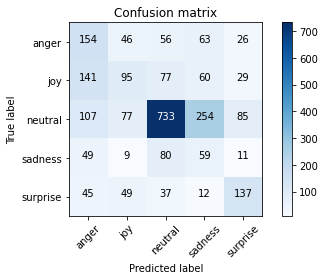

In [ ]:
plot_confusion_matrix(cm_test,label2int)

In [ ]:
print(classification_report(y_true, y_pred, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

       anger    0.31048   0.44638   0.36623       345
         joy    0.34420   0.23632   0.28024       402
     neutral    0.74568   0.58360   0.65476      1256
     sadness    0.13170   0.28365   0.17988       208
    surprise    0.47569   0.48929   0.48239       280

    accuracy                        0.47290      2491
   macro avg    0.40155   0.40785   0.39270      2491
weighted avg    0.53900   0.47290   0.49533      2491



In [ ]:
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
# f1_none = f1_score(y_true, y_pred, zero_division=1)

print('F1-score (micro): ', f1_micro)
print('F1-score (weighted): ', f1_weighted)

F1-score (micro):  0.4729024488157367
F1-score (weighted):  0.4953286961045893


## Save the models for future use 

In [ ]:
# baseline_1.save('drive/MyDrive/Thesis_code/model/baseline1_TER-5emo-bal')
# baseline_2.save('drive/MyDrive/Thesis_code/model/baseline2_TER-5emo-bal')

In [ ]:
#save the final TER model
# model.save('drive/MyDrive/Thesis_code/model/BiLSTM_TER-5emo-bal')